In [5]:
import numpy as np
import scipy as sp
import tenpy.linalg.np_conserved as npc
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.model import CouplingMPOModel
from tenpy.algorithms import tebd, tdvp
from tenpy.networks.site import SpinHalfSite
from tenpy.models.lattice import Chain
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm



In [7]:
def createPauliString(nsites, position, symbols):
    pauliString = ""
    for i in range(nsites):
        if i not in position:
            pauliString += "I"
        else:
            pauliString += symbols[position.index(i)]

    return pauliString

def pauliStr2Matrix(str):
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])
    
    if str[0] == 'I':
        mat = I
    elif str[0] == 'X':
        mat = X
    elif str[0] == 'Y':
        mat = Y
    elif str[0] == 'Z':
        mat = Z

    for i in range(len(str)-1):
        if str[i+1] == 'I':
            mat = np.kron(mat, I)
        elif str[i+1] == 'X':
            mat = np.kron(mat, X)
        elif str[i+1] == 'Y':
            mat = np.kron(mat, Y)
        elif str[i+1] == 'Z':
            mat = np.kron(mat, Z)
    
    return mat

def number2Spin(nsites, number):
    spin = np.empty(nsites, dtype=object)
    binary = format(number, f'0{nsites}b')
    for i in range(nsites):
        if binary[i] == '0':
            spin[i] = "up"
        else:
            spin[i] = "down"
    return spin

def thermalState(beta, H):
    rho = sp.linalg.expm(-beta * H)
    rho = rho / np.trace(rho)
    return rho

def computeExpectationValue(rho, operator):
    return np.real(np.trace(rho@operator))

def computeExpectationValueState(state, operator):
    return np.real(np.vdot(state, operator@state))



[Qibo 0.2.17|WARNING|2025-04-16 14:31:06]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
C:\Users\andre\AppData\Local\Temp\ipykernel_35892\585955211.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  tr[i] = np.trace(sp.linalg.expm(-beta[i] * H))


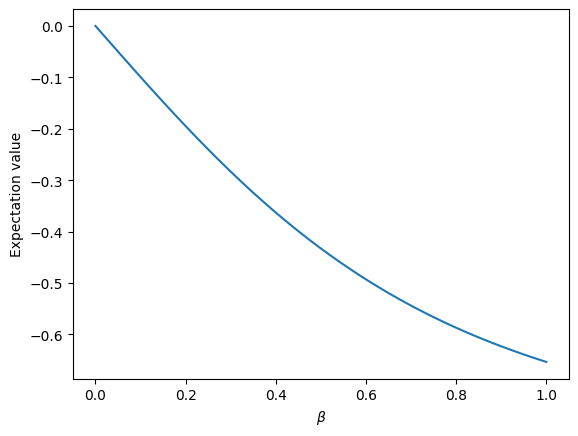

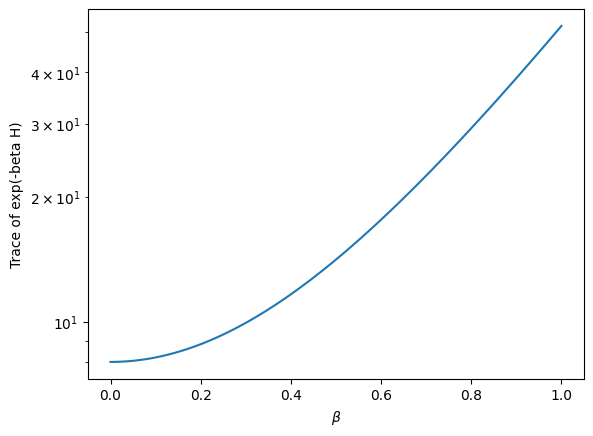

In [264]:
nqubits = 3
H_def = sum([+Z(x) + X(x)*X(x+1) for x in range(nqubits-1)])
H_def += +Z(nqubits-1) #- X(0)*X(nqubits-1)
H = hamiltonians.SymbolicHamiltonian(H_def).matrix


observable = createPauliString(nqubits, [0], ['Z'])
beta = np.linspace(0, 1, 100)
expectations = np.zeros(len(beta))
tr = np.empty(len(beta))
for i in range(len(beta)):
    rho = thermalState(beta[i], H)
    operator = pauliStr2Matrix(observable)
    tr[i] = np.trace(sp.linalg.expm(-beta[i] * H))
    expectations[i] = computeExpectationValue(rho, operator)

plt.figure()
plt.plot(beta, expectations)
plt.xlabel(r'$\beta$')
plt.ylabel('Expectation value')

plt.figure()
plt.plot(beta, tr)
plt.xlabel(r'$\beta$')
plt.ylabel('Trace of exp(-beta H)')
plt.yscale('log')

C:\Users\andre\AppData\Local\Temp\ipykernel_35892\2600783719.py:23: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(beta, expectations2[i,:], label=number2Spin(nqubits,i))


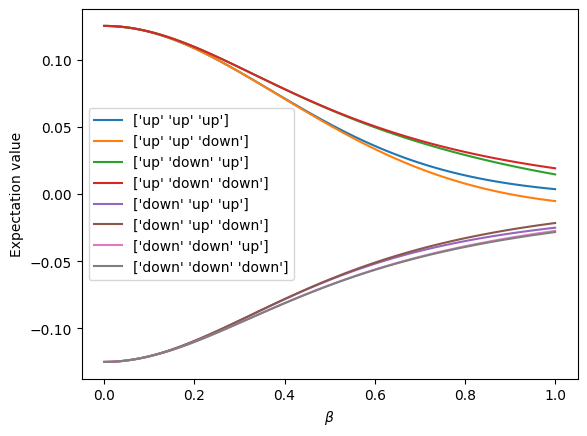

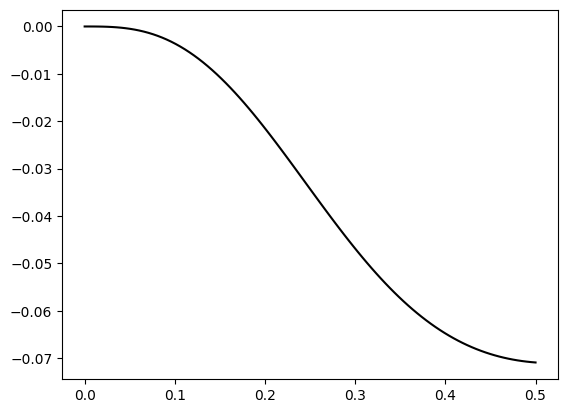

In [ ]:
nqubits = 3
beta = np.linspace(0, 1, 100)
expectations2 = np.zeros((2**nqubits,len(beta)))
operator = pauliStr2Matrix(createPauliString(nqubits, [0], ['Z']))
eigenvalues, eigenvectors = np.linalg.eig(H)


plt.figure()

for i in range(2**nqubits):
    state = np.zeros(2**nqubits)
    state[i] = 1

    for j in range(len(beta)):
        evo = sp.linalg.expm(-0.5 * beta[j] * H)
        newState = evo @ state
        #newState /= np.linalg.norm(newState)
        #normalization = np.trace(sp.linalg.expm(-beta[j] * H))
        normalization = 2**(nqubits)*(1+nqubits*beta[j]**2)
        expectations2[i,j] = computeExpectationValueState(newState, operator)
        expectations2[i,j] /= normalization

    plt.plot(beta, expectations2[i,:], label=number2Spin(nqubits,i))

plt.xlabel(r'$\beta$')
plt.ylabel('Expectation value')
plt.legend()

mean = np.zeros(len(beta))
for i in range(2**nqubits):
    mean += expectations2[i,:]
#mean /= 2**nqubits
plt.figure()
plt.plot(beta/2, mean, label='mean', color='black')


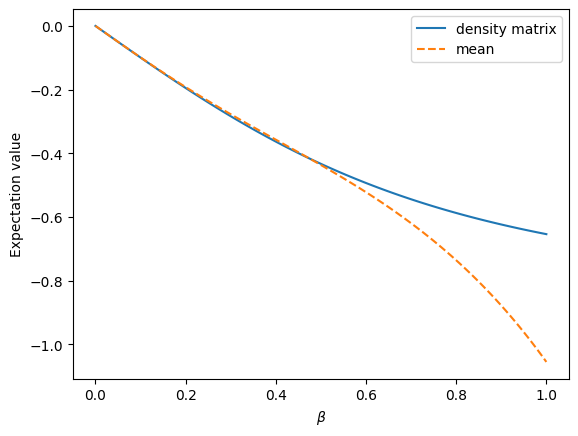

In [266]:
plt.figure()
plt.plot(beta, expectations, label='density matrix')
plt.plot(beta, mean, '--', label='mean')
plt.xlabel(r'$\beta$')
plt.ylabel('Expectation value')
plt.legend()
plt.show()

In [181]:
class CombinedTFIMIdentityModel(CouplingMPOModel):
    def init_sites(self, model_params):
        # Using SpinHalfSite for qubits (spin-1/2 systems)
        return SpinHalfSite(conserve=None)
    
    # def init_lattice(self, model_params):
    #     # Create a chain with 2N sites
    #     L = model_params.get('L', 10)  # Total sites = 2N
    #     site = self.init_sites(model_params)
    #     return Chain(L, site, bc="open", bc_MPS="finite")
    
    def init_terms(self, model_params):
        N = self.lat.N_sites // 2  # Assuming 2N sites total
        J = model_params.get('J', 1.0)  # Ising coupling
        g = model_params.get('g', 1.0)  # Transverse field
        
        # Add TFIM terms to the first N sites
        # for u in range(N-1):
        #     self.add_coupling(-J, u, 'Sz', u+1, 'Sz', 1)
        for u in range(N):
            self.add_onsite(g, u, 'Sx')
        

In [ ]:
def create_maximally_entangled_state(L):
    N = L // 2
    site = SpinHalfSite(conserve=None)
    pairs = [(i, N+i) for i in range(N)]
    psi = MPS.from_singlets(site, L, pairs) 
    return psi

def imaginary_time_evolution_entangled(L=5, J=1.0, g=1.0, beta_max=5.0, dbeta=0.05, chi_max=50):
    """
    Perform imaginary time evolution with maximally entangled initial state.
    
    Parameters:
    N : int
        Number of active sites (total system size will be 2*N)
    J : float
        Coupling strength for the Ising interaction (σz σz)
    g : float
        Transverse field strength (σx term)
    beta_max : float
        Final inverse temperature (total imaginary time)
    dbeta : float
        Imaginary time step size
    chi_max : int
        Maximum bond dimension for MPS truncation
    """
    L_full = 2*L
    
    model_params = {
        'L': L_full,
        'J': J,
        'g': g,
        'bc_MPS': 'finite',
        'sort_charge': True,
        'conserve': None,
    }
    model = TFIChain(model_params)
    psi = create_maximally_entangled_state(L_full)

    # Create a random product state of interger spins
    # sites = model.lat.mps_sites()
    # state_labels = np.empty(L_full, dtype =object)
    # for i in range(L_full):
    #     if np.random.random() < 0.5:
    #         state_labels[i] = 'up'
    #     else:
    #         state_labels[i] = 'down'
    # psi = MPS.from_product_state(sites, state_labels, bc=model.lat.bc_MPS)
    print(psi.chi)

    tebd_params = {
        'order': 1,                  
        'dt': -1.j * dbeta,          
        'N_steps': 1,
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10,
            'trunc_cut': None
        },
        'prserve_norm' : False,
        'verbose': 0
    }
    engine = tdvp.TwoSiteTDVPEngine(psi, model, tebd_params)
    #engine = tebd.TEBDEngine(psi, model, tebd_params)
    steps = int(beta_max / dbeta)
    expectation = np.zeros(steps)
    for i in range(int(beta_max / dbeta)):
        engine.run()
        #expectation[i] = psi.expectation_value_term([('Sigmaz', 0), ('Sigmaz', 2)])
        #expectation[i] = psi.expectation_value_term([('Sigmaz', 0)])
    return None

def imaginary_time_evolution_random(L=5, J=1.0, g=1.0, beta_max=1.0, dbeta=0.05):
    """
    Perform imaginary time evolution with a random computational basis state.
    
    Parameters:
    N : int
        Number of active sites (total system size will be 2*N)
    J : float
        Coupling strength for the Ising interaction (σz σz)
    g : float
        Transverse field strength (σx term)
    beta_max : float
        Final inverse temperature (total imaginary time)
    dbeta : float
        Imaginary time step size
    """
    
    model_params = {
        'L': L,
        'J': J,
        'g': g,
        'bc_MPS': 'finite',
        'sort_charge': True,
        'conserve': None,
    }
    model = TFIChain(model_params)

    # Create a random product state of interger spins
    sites = model.lat.mps_sites()
    state_labels = np.empty(L, dtype =object)
    for i in range(L):
        if np.random.random() < 0.5:
            state_labels[i] = 'up'
        else:
            state_labels[i] = 'down'
    psi = MPS.from_product_state(sites, state_labels, bc=model.lat.bc_MPS)

    tebd_params = {
        'trunc_params': {
            'svd_min': 1.e-10,
            'trunc_cut': None
        },
        'prserve_norm' : False

        }
    #engine = tdvp.TwoSiteTDVPEngine(psi, model, tebd_params)
    engine = tebd.TEBDEngine(psi, model, tebd_params)
    # Calculate evolution operators for imaginary time
    engine.calc_U(order=2, delta_t=dbeta, type_evo='imag')
    
    steps = int(0.5* beta_max / dbeta)

    expectation = np.zeros(steps)
    betaTot = 0
    for i in range(steps):
        # Evolve for one step of imaginary time
        engine.evolve(N_steps=1, dt=dbeta)
        betaTot += dbeta
        # Measure observable after each step
        expectation[i] = psi.expectation_value_term([('Sigmaz', 0)])/(2**L*(1+L*(betaTot)**2))

    return expectation

def imaginary_time_evolution_exact(L=5, J=1.0, g=1.0, beta_max=1.0, dbeta=0.05):
    """
    Perform imaginary time evolution with a random computational basis state.
    
    Parameters:
    N : int
        Number of active sites (total system size will be 2*N)
    J : float
        Coupling strength for the Ising interaction (σz σz)
    g : float
        Transverse field strength (σx term)
    beta_max : float
        Final inverse temperature (total imaginary time)
    dbeta : float
        Imaginary time step size
    """
    
    model_params = {
        'L': L,
        'J': J,
        'g': g,
        'bc_MPS': 'finite',
        'sort_charge': True,
        'conserve': None,
    }
    steps = int(beta_max / dbeta)

    model = TFIChain(model_params)
    expectation = np.zeros((2**L, steps))
    sites = model.lat.mps_sites()
    for i in range(2**L):

        state_labels = number2Spin(L, i)
        
        psi = MPS.from_product_state(sites, state_labels, bc=model.lat.bc_MPS)

        tebd_params = {
            'preserve_norm' : False,
            'trunc_params': {
                'chi_max': None,  
                'svd_min': None,
            }
        }
        
        engine = tebd.TEBDEngine(psi, model, tebd_params)
        engine.calc_U(order=2, delta_t=dbeta, type_evo='imag')
        betaTot = 0
        for j in range(steps):
            engine.evolve(N_steps=1, dt=dbeta)
            betaTot += dbeta
            expectation[i,j] = psi.expectation_value_term([('Sigmaz', 0)])/(2**L*(1+L*betaTot**2))
    return expectation

In [313]:
iters = 10
beta_max = 5.0
dbeta = 0.01
steps = int(0.5*beta_max / dbeta)
means = np.zeros(steps)
expectation = np.zeros((iters, steps))
for i in range(iters):
    expectation[i,:] = imaginary_time_evolution_random(L=3, J=-1.0, g=-1.0, beta_max=beta_max, dbeta=dbeta)
for j in range(steps):
    means[j] = np.mean(expectation[:,j])

c:\Users\andre\Desktop\EPFL\Master-Project\ImaginaryTimeEvolutionPauliPropagation\.venv\Lib\site-packages\tenpy\tools\params.py:232: UserWarning: unused options for config TEBDEngine:
['norm_tol', 'preserve_norm']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
C:\Users\andre\AppData\Local\Temp\ipykernel_35892\465877937.py:7: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(expectation[i,:], label=number2Spin(nqubits,i))


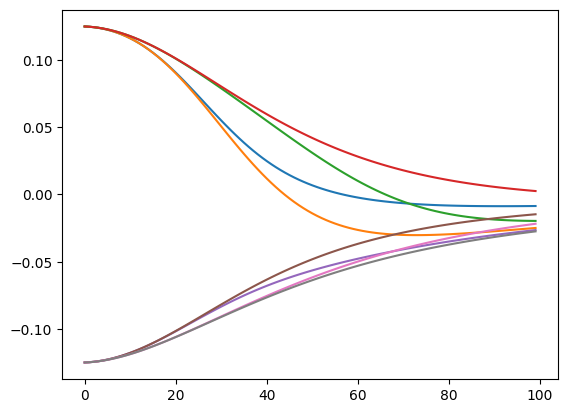

In [334]:
beta_max = 1.0
dbeta = 0.01
steps = int(0.5*beta_max / dbeta)

expectation = imaginary_time_evolution_exact(L=nqubits, J=-1.0, g=-1.0, beta_max=beta_max, dbeta=dbeta)
for i in range(2**nqubits):
    plt.plot(expectation[i,:], label=number2Spin(nqubits,i))


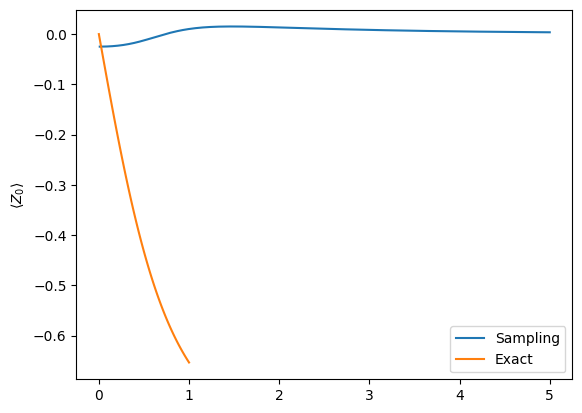

In [308]:
time = np.linspace(dbeta, beta_max, steps)
plt.figure()
plt.plot(time, means, label="Sampling")
plt.plot(beta, expectations, label ="Exact")

plt.ylabel(r'$\langle Z_{0} \rangle$')
plt.legend()

In [3]:
import numpy as np
import openfermion
from openfermion import FermionOperator, QubitOperator
from scipy import sparse
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [4]:
def jordan_wigner_tfim(n_sites, J=1.0, h=1.0):
    """
    Construct the Bogoliubov-de Gennes matrix for the transverse-field Ising model:
    H = -J Σ σ^z_i σ^z_{i+1} - h Σ σ^x_i

    For the TFIM, the Jordan-Wigner transformation gives:
    σ^z_i → (1 - 2c^†_i c_i)
    σ^x_i → (c^†_i + c_i) for i = 0
    σ^x_i → (c^†_i + c_i)(-1)^{Σ_{j<i} c^†_j c_j} for i > 0

    Args:
        n_sites (int): Number of sites
        J (float): Coupling strength for σ^z σ^z interaction
        h (float): Transverse field strength

    Returns:
        numpy.ndarray: 2n_sites × 2n_sites BdG matrix
    """

    A = np.zeros((n_sites, n_sites))
    B = np.zeros((n_sites, n_sites))

    for i in range(n_sites-1):
        A[i, i] = h
        A[i+1, i+1] = h

    # The X terms become nearest-neighbor hopping
    for i in range(n_sites-1):
        A[i, i+1] = A[i+1, i] = -J/2


    for i in range(n_sites-1):
        B[i, i+1] = -J/2
        B[i+1, i] = J/2

    # Construct BdG matrix
    M = np.block([
        [A, B],
        [-B, -A]
    ])

    return M

def diagonalize_bdg_matrix(M):
    """
    Diagonalize the Bogoliubov-de Gennes matrix to find single-particle energies.
    """
    # Diagonalize the BdG matrix
    eigenvalues, eigenvectors = np.linalg.eigh(M)

    # The eigenvalues come in pairs (ε, -ε)
    # We only need the positive ones for the fermionic spectrum
    n = len(eigenvalues) // 2
    energies = eigenvalues[n:]  # Take the positive eigenvalues

    return energies, eigenvectors

def fermi_dirac(E, beta):
    return 1 / (1 + np.exp(beta * E))





In [32]:
def zz_correlation(M, beta, i, j):
    N = M.shape[0] // 2
    eigvals, eigvecs = np.linalg.eigh(M)

    # Positive energy modes (upper half of spectrum)
    pos_eigvals = eigvals[N:]
    pos_modes = eigvecs[:, N:]

    # Extract u and v components
    Uk = pos_modes[:N, :]  # u_k(i)
    Vk = pos_modes[N:, :]  # v_k(i)

    # Thermal occupations
    f = 1 / (np.exp(2* beta *pos_eigvals) + 1)
    
    G = Uk@np.conj(Uk).T
    F = Uk@np.conj(Vk).T

    

    # # # Correlation matrix: <c†_i c_j>
    # # C = (Uk * f) @ Uk.conj().T + (Vk * (1 - f)) @ Vk.conj().T
    # C = np.zeros((N, N), dtype=complex)
    # for a in range(N):
    #     for b in range(N):
    #         # Sum over all modes
    #         for k in range(N):
    #             # Thermal contribution from each mode   
    #             C[a, b] += np.conj(Uk[a, k]) * Uk[b, k] * f[k]
    #             C[a, b] += np.conj(Vk[a, k]) * Vk[b, k] * (1.0-f[k])

    # n_i = C[i, i].real
    # n_j = C[j, j].real

    # if i == j:
    #     return 1.0
    # else:
    #     corr = 1 - 2*n_i - 2*n_j + 4*(n_i * n_j - np.abs(C[i, j])**2)
    #     return corr.real
    #n = np.abs(j-i)
    #czz = 4/np.pi**2 * 1/(4*n**2 - 1)
    #zz = czz + f[i]*f[j]
    zz = 4*(G[i,i]-0.5)*(G[j,j]-0.5) - 4*G[i,j]*G[j,i] + 4*np.abs(F[i,j])**2
    return zz

[Qibo 0.2.17|WARNING|2025-04-24 14:17:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


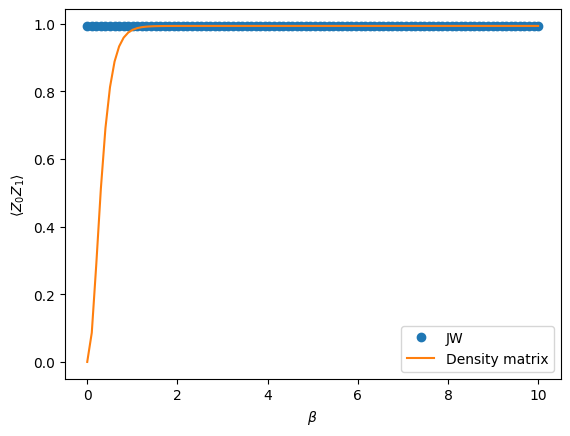

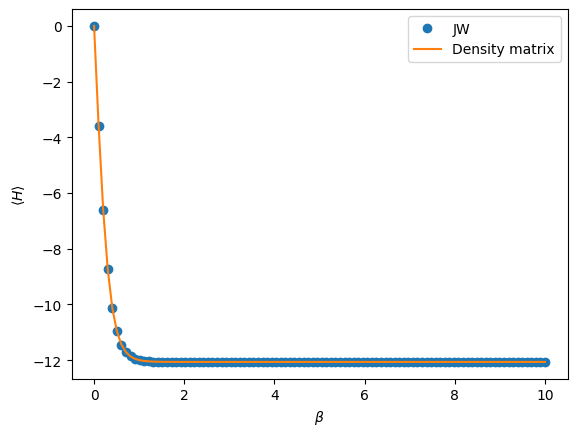

In [ ]:
nqubits = 4
J = 0.5
h = 3.0
H_def = sum([-J*X(x)*X(x+1) - h*Z(x) for x in range(nqubits-1)])  - h*Z(nqubits-1)
H = hamiltonians.SymbolicHamiltonian(H_def).matrix


beta = np.linspace(0, 10.0, 100)
expectations = np.zeros(len(beta))
energy_rho = np.zeros(len(beta))

for i in range(len(beta)):
    rho = thermalState(beta[i], H)
    operator = pauliStr2Matrix(createPauliString(nqubits, [1,2], ['Z','Z']))
    expectations[i] = computeExpectationValue(rho, operator)
    energy_rho[i] = computeExpectationValue(rho, H)

nSites = nqubits


M = jordan_wigner_tfim(nSites, J, h)

energies, eigenvectors = diagonalize_bdg_matrix(M) 

corr = np.zeros(len(beta))
energy = np.zeros(len(beta))
for i in range(len(beta)):
    corr[i] = zz_correlation(M, beta[i], 1, 2)
    n_k = fermi_dirac(energies, 2*beta[i])
    energy[i] = np.sum(energies * (2*n_k-1))
    
plt.figure()
plt.plot(beta, corr, 'o', label = 'JW')
plt.plot(beta, expectations, label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle Z_{0} Z_{1} \rangle$')
plt.legend()

plt.figure()
plt.plot(beta, energy, 'o' , label = 'JW')
plt.plot(beta, energy_rho , label = 'Density matrix')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\langle H \rangle$')
plt.legend()
plt.show()

